In [1]:
# Install required libraries
!pip install gym gym[atari] gym[accept-rom-license] numpy networkx matplotlib pgmpy


  Using cached ale_py-0.8.1-cp311-cp311-win_amd64.whl.metadata (8.3 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/952.4 kB ? eta -:--:--
   ---------------------- ----------------- 524.3/952.4 kB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 952.4/952.4 kB 3.2 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446687 sha256=8de46d338b0ef13dd5fdb31e736f28fe5bed4d222ed3f948812b26a5c6989a18
  Stored in directory: c:\users\jainl\appdata\local\pip\cache\wheels\bc\fc\c6\8aa657c0d2089982f2dabd110efc68c61eb49831fdb7397351
Successfully built AutoROM.accept-rom-license


In [2]:
import gym
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [9]:
env = gym.make('MontezumaRevenge-v0')


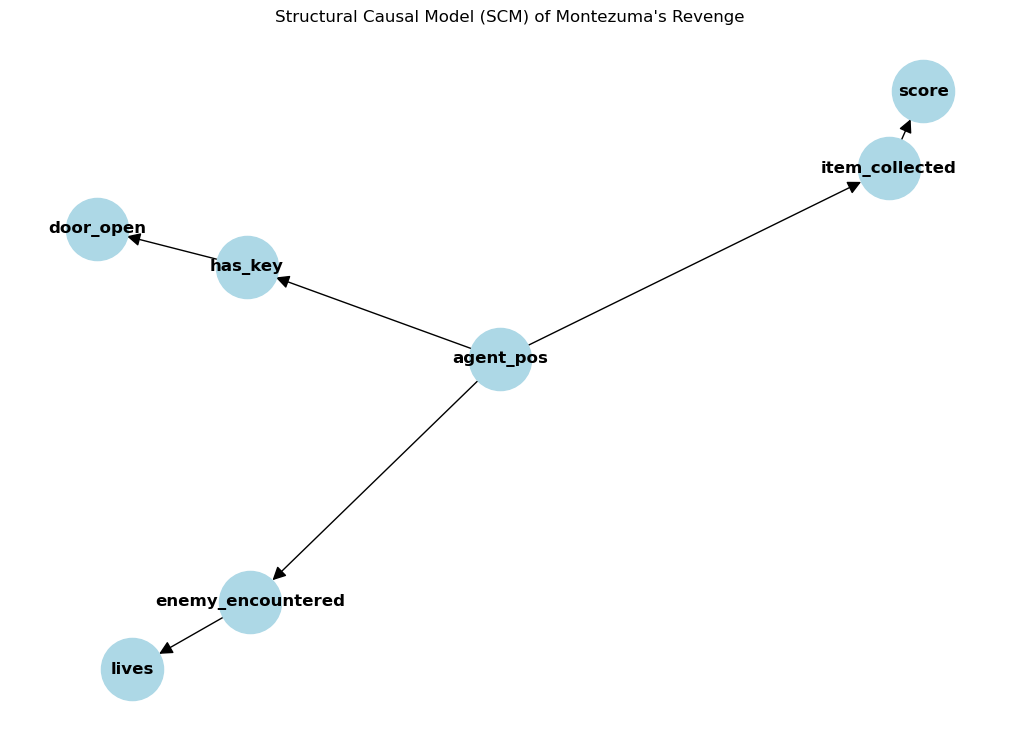

In [4]:
# Define the SCM as a directed graph
SCM = nx.DiGraph()
SCM.add_edges_from([
    ('agent_pos', 'has_key'),
    ('has_key', 'door_open'),
    ('agent_pos', 'enemy_encountered'),
    ('enemy_encountered', 'lives'),
    ('agent_pos', 'item_collected'),
    ('item_collected', 'score'),
])

# Draw the SCM
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(SCM)
nx.draw(SCM, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=12, font_weight='bold', arrowsize=20)
plt.title('Structural Causal Model (SCM) of Montezuma\'s Revenge')
plt.show()


In [5]:
class CausalAgent:
    def __init__(self):
        # Initialize empty causal graph
        self.internal_causal_graph = nx.DiGraph()
        self.variables = ['agent_pos_x', 'agent_pos_y', 'has_key', 'door_open', 'score', 'lives', 'enemy_encountered', 'item_collected']
        self.internal_causal_graph.add_nodes_from(self.variables)
        
        # Data storage for causal discovery
        self.data = []
        self.pos = None  # For consistent node positions
        
    def update_causal_graph(self):
        if len(self.data) < 100:  # Wait until we have enough data
            return
        
        # Convert data to a DataFrame
        import pandas as pd
        df = pd.DataFrame(self.data)
        
        # Use Hill Climb Search with BicScore
        from pgmpy.estimators import HillClimbSearch, BicScore
        hc = HillClimbSearch(df)
        best_model = hc.estimate(scoring_method=BicScore(df))
        
        # Update the internal causal graph
        self.internal_causal_graph = nx.DiGraph()
        self.internal_causal_graph.add_nodes_from(best_model.nodes())
        self.internal_causal_graph.add_edges_from(best_model.edges())
        
        # Compute layout once
        if self.pos is None:
            self.pos = nx.spring_layout(self.internal_causal_graph)
        
        # Visualize the learned causal graph
        plt.figure(figsize=(10, 7))
        nx.draw(self.internal_causal_graph, self.pos, with_labels=True, node_size=2000, node_color='lightgreen',
                font_size=10, font_weight='bold', arrowsize=20)
        plt.title('Agent\'s Internal Causal Graph')
        plt.show()
        
    def decide_action(self, observation):
        # Placeholder for decision-making logic
        # For simplicity, we'll perform random actions
        return env.action_space.sample()
    
    def perform_intervention(self, env):
        # Interventions are more challenging in a pre-defined environment like Montezuma's Revenge
        # We may simulate interventions by manipulating observations or using wrappers
        pass


In [6]:
def extract_features(observation, info):
    # This function extracts features from the observation and info dictionaries
    # For illustration, we'll assume we can get these variables directly
    # In practice, you'd need to process the image or use environment wrappers
    
    # Extract agent's position (if available)
    # For this example, we'll set dummy values
    agent_pos_x = np.random.randint(0, 160)  # Screen width in pixels
    agent_pos_y = np.random.randint(0, 210)  # Screen height in pixels
    
    # Extract other variables from info or set defaults
    has_key = False  # Placeholder
    door_open = False  # Placeholder
    score = info.get('score', 0)
    lives = info.get('lives', 3)
    enemy_encountered = False  # Placeholder
    item_collected = False  # Placeholder
    
    features = {
        'agent_pos_x': agent_pos_x,
        'agent_pos_y': agent_pos_y,
        'has_key': int(has_key),
        'door_open': int(door_open),
        'score': score,
        'lives': lives,
        'enemy_encountered': int(enemy_encountered),
        'item_collected': int(item_collected),
    }
    return features


In [8]:
# Initialize environment and agent
env = gym.make('MontezumaRevenge-v0')
agent = CausalAgent()

num_episodes = 5
max_steps_per_episode = 1000  # Montezuma's Revenge requires more steps

for episode in range(num_episodes):
    observation = env.reset()
    done = False
    total_reward = 0
    print(f'\nEpisode {episode + 1}')
    
    for step in range(max_steps_per_episode):
        env.render(mode='human')
        
        # Agent decides on an action
        action = agent.decide_action(observation)
        
        # Take a step in the environment
        observation, reward, done, info = env.step(action)
        total_reward += reward
        
        # Extract features from the observation
        features = extract_features(observation, info)
        
        # Collect data for causal discovery
        agent.data.append(features)
        
        # Periodically update the internal causal graph
        if step % 500 == 0:
            agent.update_causal_graph()
        
        if done:
            print(f'Episode finished after {step + 1} steps with total reward {total_reward}')
            break
    
    # Update and visualize the internal causal graph after each episode
    agent.update_causal_graph()



Episode 1


TypeError: AtariEnv.render() got an unexpected keyword argument 'mode'